In [1]:
%pylab notebook

import pandas as pd
import numpy as np
import datetime
import os

import ipywidgets as widgets

from cognite.config import configure_session
from cognite.v05.timeseries import get_datapoints_frame, get_timeseries
from cognite.v05.assets import get_asset, get_assets, get_asset_subtree
from cognite.v05.events import get_events, get_event, search_for_events

Populating the interactive namespace from numpy and matplotlib


In [2]:
configure_session(os.environ.get('Public_key'), 'publicdata')

In [3]:
p_in_tag  = 'VAL_23-PT-92532:X.Value'
T_in_tag  = 'VAL_23_TT_92532:Z.X.Value'
Q_tag     = 'VAL_23-FT-92537-01:X.Value'
p_out_tag = 'VAL_23-PT-92539:X.Value'
T_out_tag = 'VAL_23_TT_92536:Z.X.Value'
all_tags  = [p_in_tag, T_in_tag, Q_tag, T_out_tag, p_out_tag]

In [158]:
# Training - test set
# Question: Why not random?

train_start = datetime.datetime(2014, 1, 1)
train_end   = datetime.datetime(2016, 1, 1)
predict_end = datetime.datetime(2017, 1, 1)

start = train_start
end = predict_end
data = get_datapoints_frame(all_tags, 
                            start=start, 
                            end=end,
                            granularity='10m', 
                            aggregates=['avg'])

In [159]:
df = data.fillna(method='ffill')
df = df.fillna(method='bfill')

In [160]:
train_cond = df.timestamp < train_end.timestamp()*1000
df_train = df[train_cond]
df_test  = df[~train_cond]

In [174]:
y_train = df_train[p_out_tag+'|average']
X_train = df_train.drop([p_out_tag+'|average','timestamp'], axis=1)
y_test = df_test[p_out_tag+'|average']
X_test = df_test.drop([p_out_tag+'|average','timestamp'], axis=1)

In [175]:
from lightgbm import LGBMRegressor
gm = LGBMRegressor(n_estimators=450)

In [176]:
gm.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=450,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [177]:
y_pred = gm.predict(X_test)

<IPython.core.display.Javascript object>


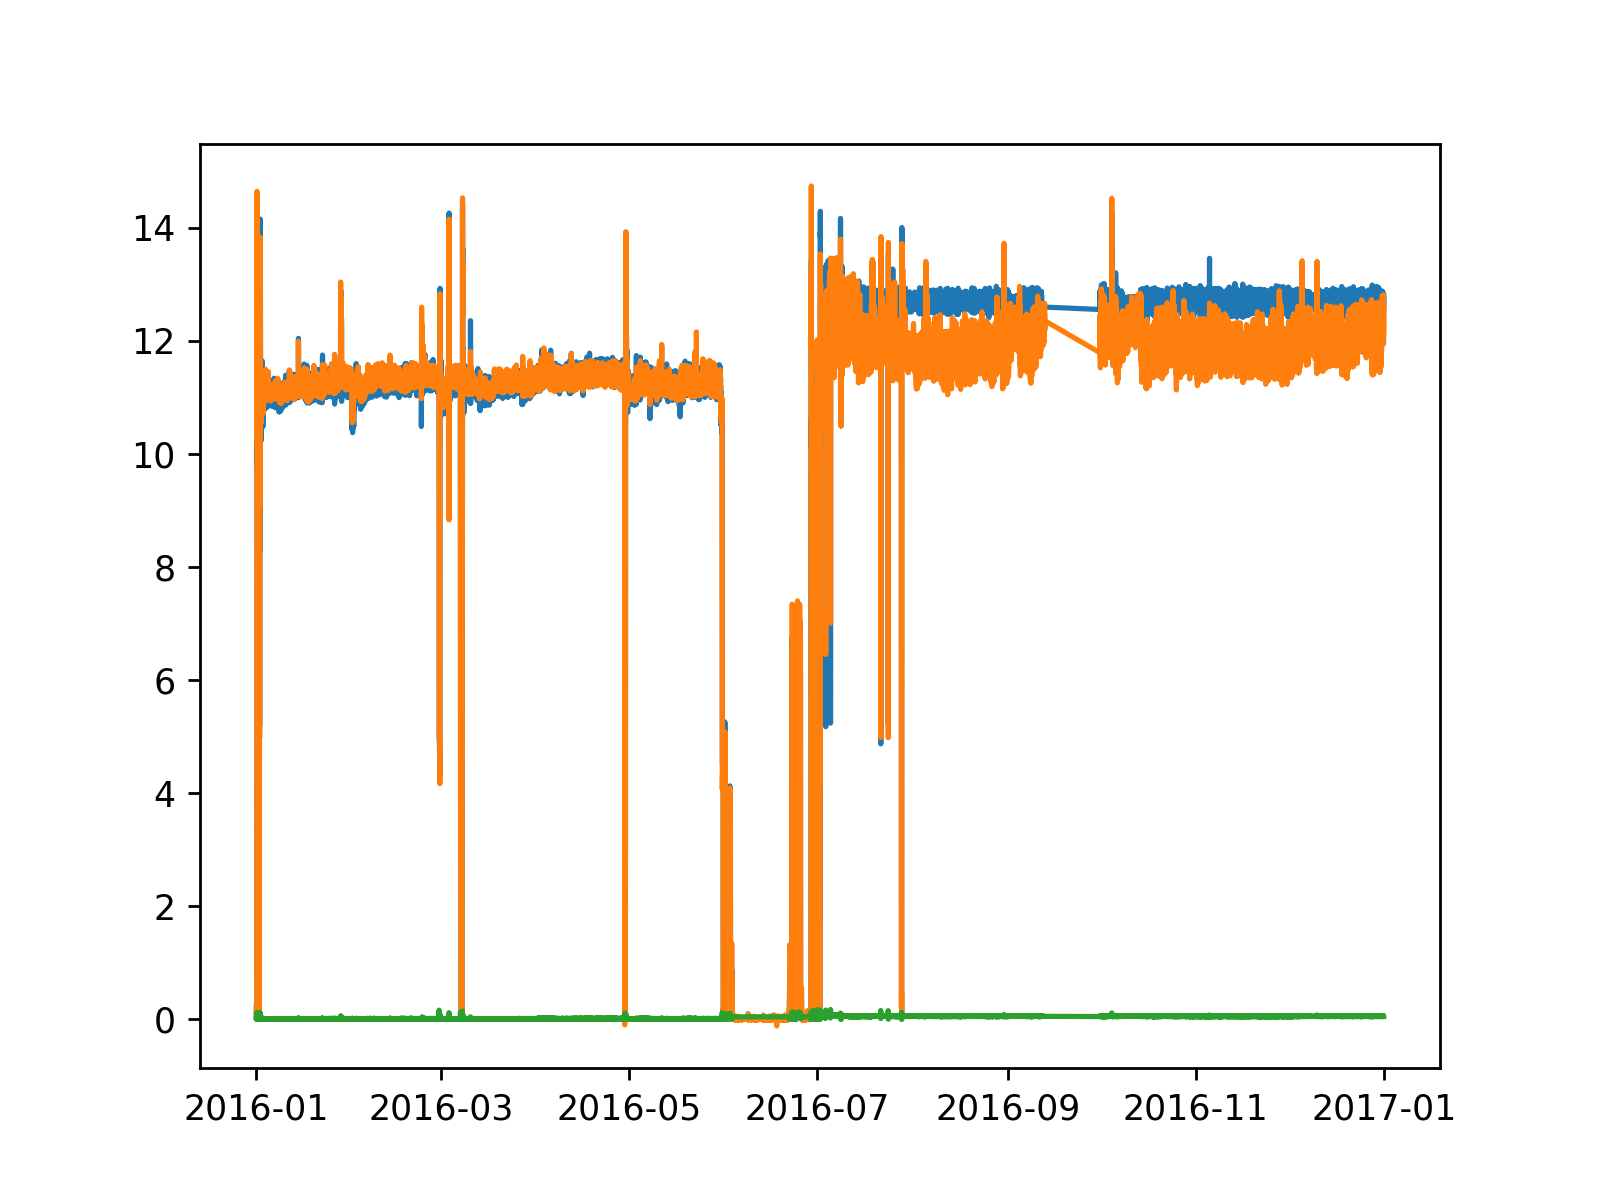

In [178]:
plt.figure()
plt.plot(t_test, y_test)
plt.plot(t_test, y_pred)
plt.plot(t_test, e)

<IPython.core.display.Javascript object>


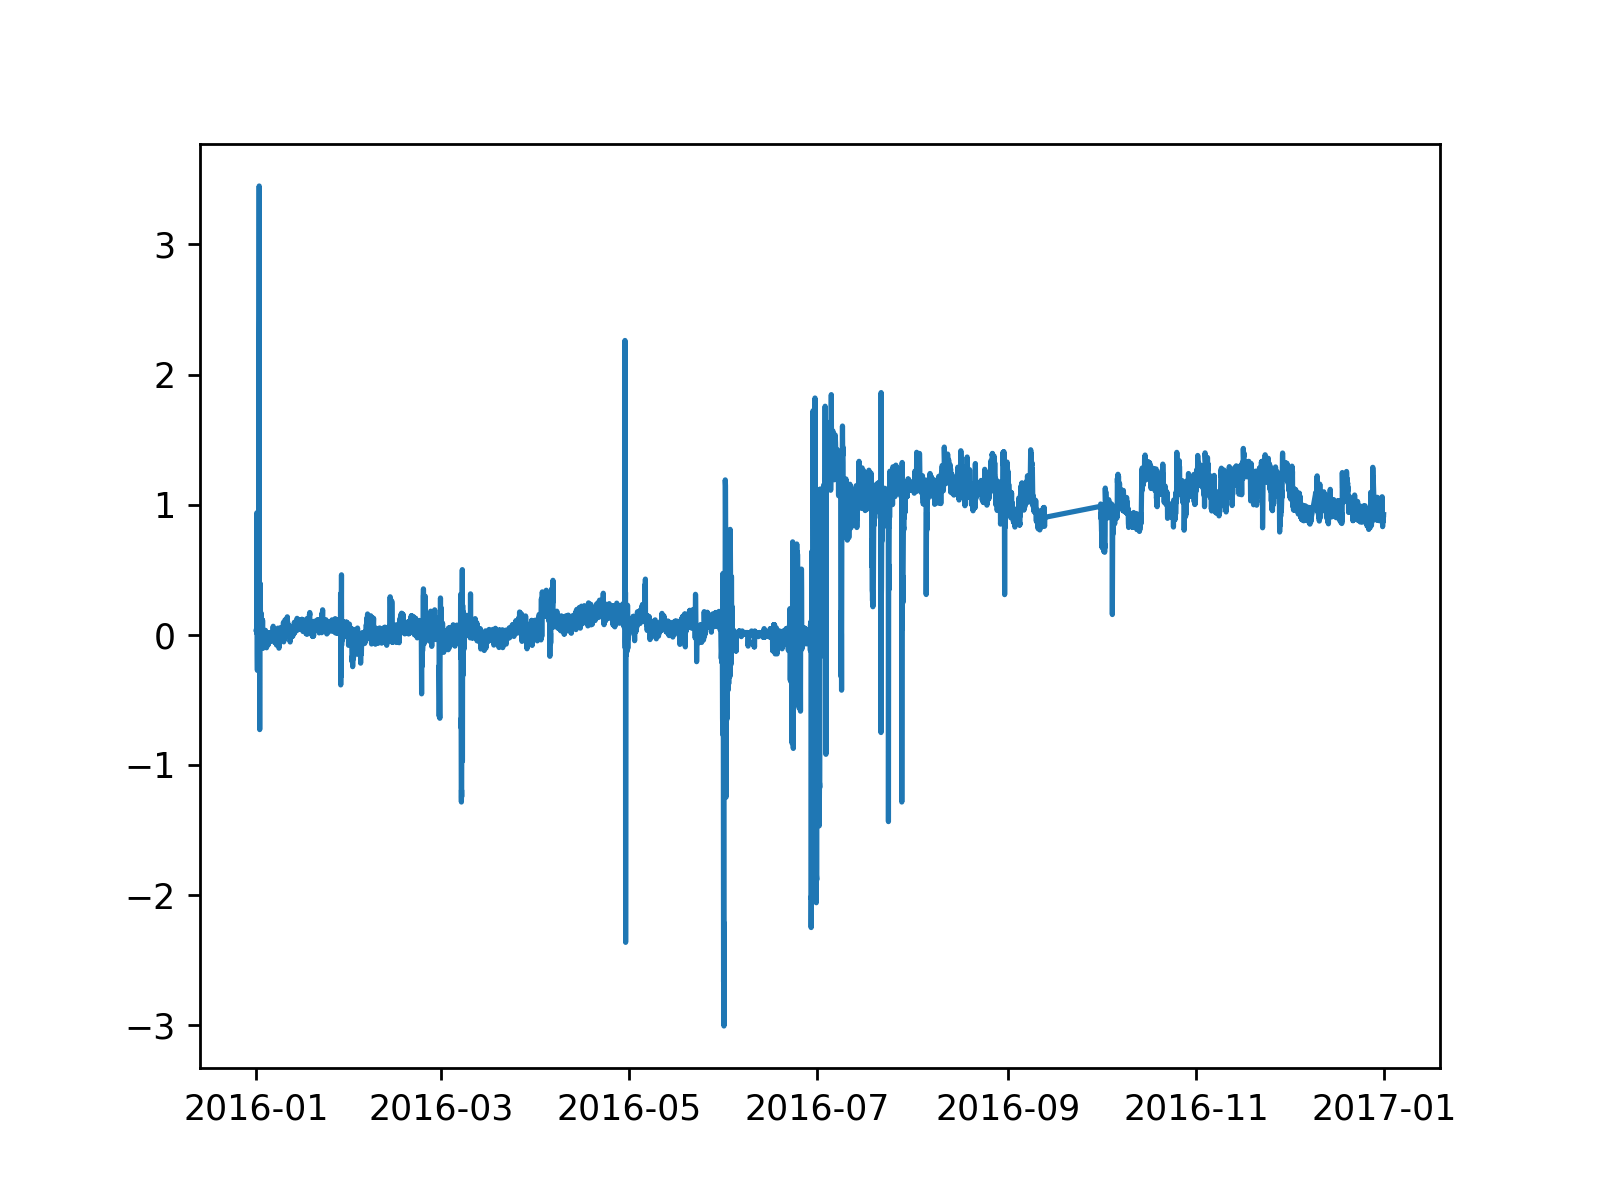

In [156]:
e = y_test - y_pred
plt.figure()
plt.plot(t_test, e)